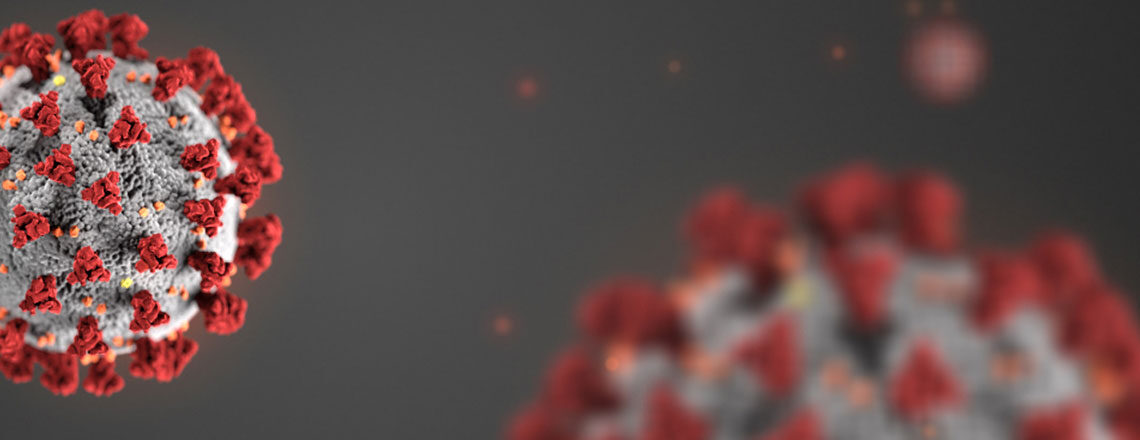

 # San Diego County COVID-19



## Analyzing San Diego Coronavirus cases 

On February 11, 2020 the World Health Organization announced an official name for the disease that is causing the 2019 novel coronavirus outbreak, first identified in Wuhan China. The new name of this disease is coronavirus disease 2019, abbreviated as COVID-19. In COVID-19, ‘CO’ stands for ‘corona,’ ‘VI’ for ‘virus,’ and ‘D’ for disease. Formerly, this disease was referred to as “2019 novel coronavirus” or “2019-nCoV”.

Coronavirus continues to grow in San Diego County, California. Pandemic has shut down or significantly altered most of the economy, testing the resilience of all San Diegans. Necessary public health measures to prevent the spread of the virus have halted tourism, shuttered restaurants and bars, forced many to work from home, severly limited most businesses from. interacting with their customers, and caused unemployment and uncertainty for tens of thousands in the San Diego region.

This project uses https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-by-zip-code?geometry=-120.818%2C32.167%2C-112.908%2C33.780

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import folium
from sklearn import  linear_model
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import weibull_min, lognorm, logistic, norm
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()

import warnings
warnings.filterwarnings('ignore')

# Import Data


In [2]:
stats_df = pd.read_csv('COVID_19_Statistics_San_Diego_County.csv')
zip_df = pd.read_csv('COVID-19_Statistics_by_ZIP_Code.csv')

In [3]:
stats_df.head()

,X,Y,objectid,date,tests,positives,hospitalized,icu,deaths,newcases,...,age80_plus,ageunknow,age20_29,genderfemale,gendermale,gendeunk,age30_39,globalid,newtests,rolling_perc_pos_cases
0,-1.299488e+07,3.899796e+06,59,2020/03/11 08:00:00+00,123.0,5,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{78698F35-A6E9-48CB-8C8D-67A70EC15C1D},NaN,NaN
1,-1.299488e+07,3.899796e+06,60,2020/03/12 08:00:00+00,147.0,10,NaN,NaN,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{EFA2B0DB-A692-4632-8495-14B46E240096},NaN,NaN
2,-1.299488e+07,3.899796e+06,61,2020/03/13 08:00:00+00,273.0,19,NaN,NaN,NaN,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{AA7DF18A-6303-4758-A5F1-9B9CD4388A92},52.0,NaN
3,-1.299488e+07,3.899796e+06,62,2020/03/14 08:00:00+00,288.0,25,12.0,NaN,NaN,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{9A014068-714D-4FD4-B011-A16A1A49C07C},14.0,NaN
4,-1.299488e+07,3.899796e+06,63,2020/03/15 08:00:00+00,313.0,37,10.0,NaN,NaN,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{DA54D0B2-3C90-4FF2-8090-BE3BDB8C1B4E},25.0,NaN


In [4]:
zip_df.head()

,X,Y,objectid,zipcode_zip,ziptext,case_count,updatedate,created_user,created_date,last_edited_user,last_edited_date,globalid,rate_100k,test_positive,test_neg,test_ind,test_total,test_100k,tests_pct_positive
0,-1.299049e+07,3.869543e+06,1,91901.0,91901,1.0,2020/04/01 08:00:00+00,Ross.Martin@sdcounty.ca.gov,2020/04/11 18:43:45+00,Ross.Martin@sdcounty.ca.gov,2020/04/11 18:43:45+00,{87C2AEFB-2AB8-473D-BE60-B021F0AD990A},NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.302606e+07,3.851793e+06,2,91902.0,91902,9.0,2020/04/01 08:00:00+00,Ross.Martin@sdcounty.ca.gov,2020/04/11 18:43:45+00,Ross.Martin@sdcounty.ca.gov,2020/04/11 18:43:45+00,{0BBF31F5-A98F-4A42-869E-F425379D6BA8},NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.303169e+07,3.847143e+06,3,91910.0,91910,23.0,2020/04/01 08:00:00+00,Ross.Martin@sdcounty.ca.gov,2020/04/11 18:43:45+00,Ross.Martin@sdcounty.ca.gov,2020/04/11 18:43:45+00,{94FEB6AB-AB77-4534-9692-CF8DFC823461},NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.302997e+07,3.843296e+06,4,91911.0,91911,21.0,2020/04/01 08:00:00+00,Ross.Martin@sdcounty.ca.gov,2020/04/11 18:43:45+00,Ross.Martin@sdcounty.ca.gov,2020/04/11 18:43:45+00,{83793CC0-427A-4747-9BDD-5D79A947C3FF},NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.302299e+07,3.844480e+06,5,91913.0,91913,20.0,2020/04/01 08:00:00+00,Ross.Martin@sdcounty.ca.gov,2020/04/11 18:43:45+00,Ross.Martin@sdcounty.ca.gov,2020/04/11 18:43:45+00,{597D4C08-7AD1-49D2-811D-D54EE7C2BB13},NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1. Cleaning Data

In [5]:
df = stats_df[['date','tests','positives','hospitalized','icu','deaths']].sort_values('date')
df['date'] = pd.to_datetime(df.date)

df.columns = ['date', 'tests', 'cases', 'hosp','icu', 'deaths']
df['date'] = pd.to_datetime(df.date)
start_date = df.iloc[0].date
start_cases = df.iloc[0].cases
df['day'] = (df.date - start_date).dt.days

df['new_cases'] = df.cases.diff()
df['cases_rate'] = df.cases.diff()/ df.cases.shift(1)
df['cases_smooth'] = lowess(df.cases, df.day)[:,1]
df['cases_smooth_rate'] = df.cases_smooth.diff()/df.cases_smooth.shift(1)

df['new_hosp'] = df.hosp.diff()
df['hosp_rate'] = df.hosp.diff()/ df.hosp.shift(1)
df['hosp_smooth'] = lowess(df.hosp.fillna(0), df.day)[:,1]
df['hosp_smooth_rate'] = df.hosp.diff()/df.hosp_smooth.shift(1)

df['new_deaths'] = df.deaths.diff()
df['deaths_rate'] = df.deaths.diff()/ df.deaths.shift(1)
df['deaths_smooth'] = lowess(df.deaths.fillna(0), df.day)[:,1]
df['deaths_smooth_rate'] = df.deaths_smooth.diff()/df.deaths_smooth.shift(1)

#df['double_days'] = np.log(2)/np.log(1+df.cases_smooth_rate)


df.tail()

,date,tests,cases,hosp,icu,deaths,day,new_cases,cases_rate,cases_smooth,cases_smooth_rate,new_hosp,hosp_rate,hosp_smooth,hosp_smooth_rate,new_deaths,deaths_rate,deaths_smooth,deaths_smooth_rate
169,2020-08-23 08:00:00+00:00,784836.0,36727,2989.0,733.0,660.0,169,187.0,0.005118,37148.127663,0.009829,11.0,0.003694,3004.591718,0.003687,0.0,0.000000,664.149246,0.007631
170,2020-08-24 08:00:00+00:00,790370.0,36994,3006.0,736.0,665.0,170,267.0,0.007270,37509.879529,0.009738,17.0,0.005688,3026.083747,0.005658,5.0,0.007576,669.180804,0.007576
171,2020-08-25 08:00:00+00:00,798697.0,37222,3022.0,738.0,668.0,171,228.0,0.006163,37871.784955,0.009648,16.0,0.005323,3047.584905,0.005287,3.0,0.004511,674.214090,0.007522
172,2020-08-26 08:00:00+00:00,803932.0,37499,3040.0,738.0,673.0,172,277.0,0.007442,38233.831303,0.009560,18.0,0.005956,3069.094654,0.005906,5.0,0.007485,679.248982,0.007468
173,2020-08-27 08:00:00+00:00,812753.0,37784,3065.0,146.0,676.0,173,285.0,0.007600,38596.007148,0.009473,25.0,0.008224,3090.612505,0.008146,3.0,0.004458,684.285368,0.007415


In [6]:
df.set_index('date').cases_rate.tail(15)

date
2020-08-13 08:00:00+00:00    0.012062
2020-08-14 08:00:00+00:00    0.008190
2020-08-15 08:00:00+00:00    0.009725
2020-08-16 08:00:00+00:00    0.008132
2020-08-17 08:00:00+00:00    0.005778
2020-08-18 08:00:00+00:00    0.006086
2020-08-19 08:00:00+00:00    0.006558
2020-08-20 08:00:00+00:00    0.008537
2020-08-21 08:00:00+00:00    0.008103
2020-08-22 08:00:00+00:00    0.009309
2020-08-23 08:00:00+00:00    0.005118
2020-08-24 08:00:00+00:00    0.007270
2020-08-25 08:00:00+00:00    0.006163
2020-08-26 08:00:00+00:00    0.007442
2020-08-27 08:00:00+00:00    0.007600
Name: cases_rate, dtype: float64

### 2. Data Exploration

In [7]:
zip_df = zip_df.sort_values(by=['updatedate'])
dates = list(set(zip_df['updatedate'].to_list()))
dates = sorted(dates)
counts = []
for date in dates:
    n_df = zip_df[zip_df['updatedate'] == date]
    counts.append(n_df['case_count'].sum())

codes = list(set(zip_df['ziptext'].to_list()))
code_counts = {}
for code in codes:
    n_df = zip_df[zip_df['ziptext'] == code]
    code_counts[code] = n_df['case_count'].sum()

In [8]:
zipcode = zcdb[91911]
m = folium.Map(
    location=[zipcode.latitude, zipcode.longitude],
    zoom_start=8,
)

for code in code_counts.keys():
    count = code_counts[code]
    if count < 10000:
        color = 'green'
    elif 1000 <= count <= 50000:
        color = 'pink'
    else:
        color = 'red'
    try:
        zipcode = zcdb[code]
        folium.Marker(
            location=[zipcode.latitude, zipcode.longitude],
            popup='Case Count = '+str(count),
            icon=folium.Icon(color=color)
        ).add_to(m)
    except Exception as e:
        print('Lat lng not available for zipcode',code,'Case Count', count)
        
m

Lat lng not available for zipcode 92010 Case Count 5134.0
Lat lng not available for zipcode 92011 Case Count 6137.0
Lat lng not available for zipcode 92081 Case Count 8900.0


### Map
- `Red`: more than 50000 cases
- `Pink`: b/w 10000 and 50000 cases
- `Green`: Less than 10000 cases

### Top 10 Areas with Highest Case Count

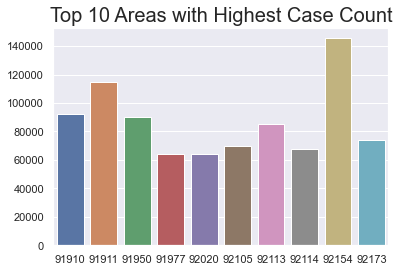

In [9]:
sorted_counts = {k: v for k, v in sorted(code_counts.items(), key=lambda item: item[1])}
top10_case_counts = [sorted_counts[k] for k in list(sorted_counts.keys())[-10:]]
top10_codes = [k for k in list(sorted_counts.keys())[-10:]]

sns.barplot(y=top10_case_counts, x=top10_codes)
plt.title('Top 10 Areas with Highest Case Count',fontsize=20)
plt.show()

### Statistical Analysis

### Box Plots

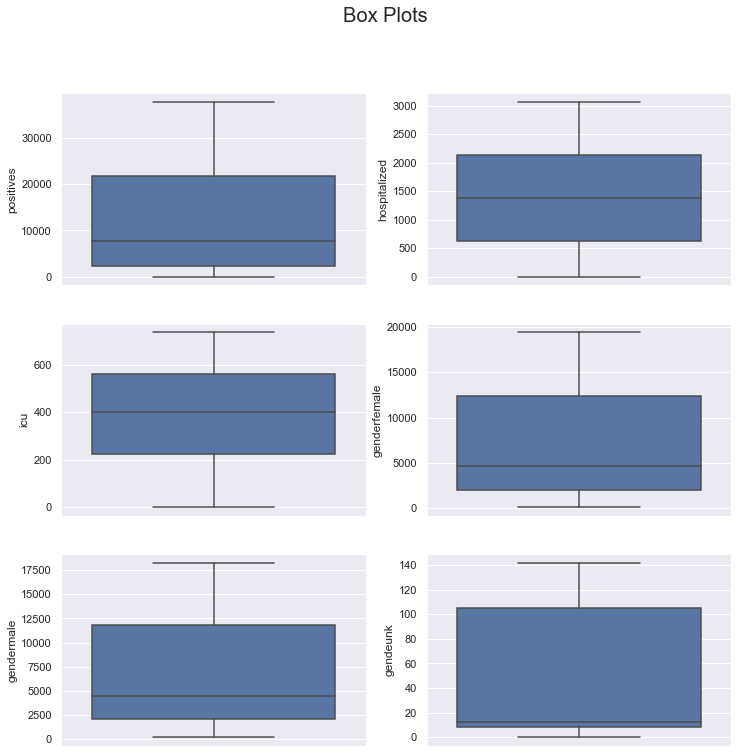

In [10]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,12))

sns.boxplot(y=stats_df["positives"], ax=axes[0,0])

sns.boxplot(y=stats_df["hospitalized"], ax=axes[0,1])


sns.boxplot(y=stats_df["icu"], ax=axes[1,0])


sns.boxplot(y=stats_df["genderfemale"], ax=axes[1,1])


sns.boxplot(y=stats_df["gendermale"], ax=axes[2,0])


sns.boxplot(y=stats_df["gendeunk"], ax=axes[2,1])

figure.suptitle("Box Plots", fontsize=20)
plt.show()

### Age vs Cases

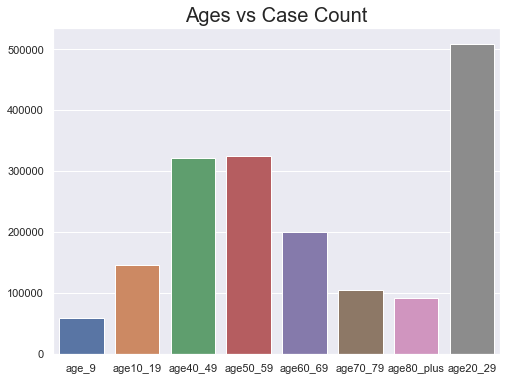

In [11]:
ages = ['age_9','age10_19','age40_49','age50_59','age60_69','age70_79','age80_plus','age20_29',]
age_count = []
for age in ages:
    age_count.append(stats_df[age].sum())
plt.figure(figsize=(8,6))
sns.barplot(y=age_count, x=ages)
plt.title('Ages vs Case Count', fontsize=20)
plt.show()

### Correlation b/w Age and Positives

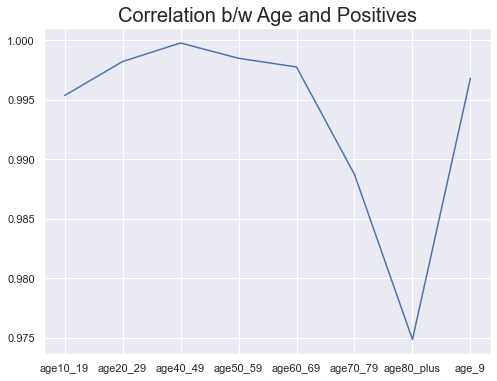

In [12]:
positives = []
newcases = []
for age in ages:
    positives.append(stats_df['positives'].corr(stats_df[age]))
    newcases.append(stats_df['newcases'].corr(stats_df[age]))
plt.figure(figsize=(8,6))

sns.lineplot(y=positives, x=ages)
plt.title('Correlation b/w Age and Positives', fontsize=20)
plt.show()

### Correlation b/w Age and New Cases

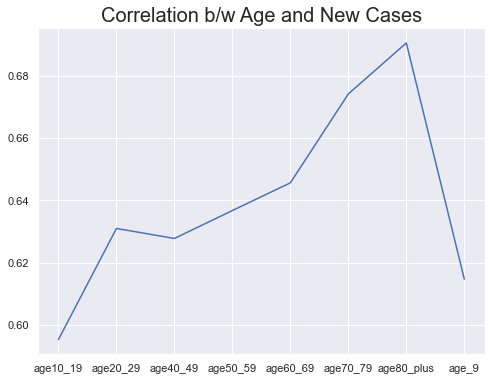

In [13]:
plt.figure(figsize=(8,6))
sns.lineplot(y=newcases, x=ages)
plt.title('Correlation b/w Age and New Cases', fontsize=20)
plt.show()

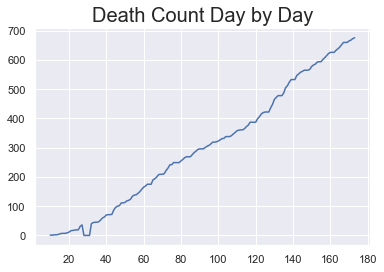

In [14]:
stats_df['deaths'].plot()
plt.title('Death Count Day by Day', fontsize=20)
plt.show()

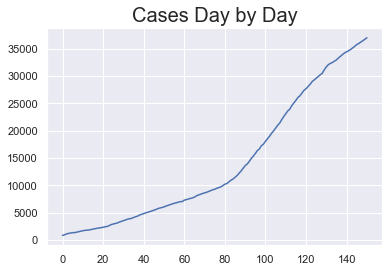

In [15]:
sns.lineplot(y=counts, x=np.arange(len(dates)))
plt.title('Cases Day by Day', fontsize=20)
plt.show()

In [16]:
def func_norm(x, loc, scale, a):
    return a*norm.pdf(x,loc, scale)
func_norm.popt =  (22, 10, 3659)

def func_logpdf(x, loc, scale, a):
    return a*logistic.pdf(x,loc, scale)
func_logpdf.popt =  (22, 10, 3659)

def func_logistic(x, loc, scale, a): # popt = (14,4, 800)
    return a*logistic.cdf(x, loc, scale)
func_logistic.popt =  (14,4, 800)


def func_erf(x, loc, scale, a, b):
    return a*erf( (x-loc) / scale ) + b
func_erf.popt = (50,20,3000,3000)

def func_gomp(x, a, b, c):
    return a * np.exp(-b * np.exp(-c * x))
func_gomp.popt = (1000,10,.1)

[1.36295352e+05 6.54360112e+00 9.70158988e-03]


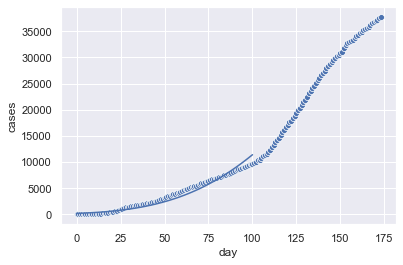

In [17]:
t = df.copy() 


popt, pcov = curve_fit(func_gomp, t.day, t.cases, absolute_sigma = True)
print(popt)

sns.scatterplot(x=t.day, y=t.cases)

x=np.linspace(0,100)


sns.lineplot(x=x, y=func_gomp(x, *popt))


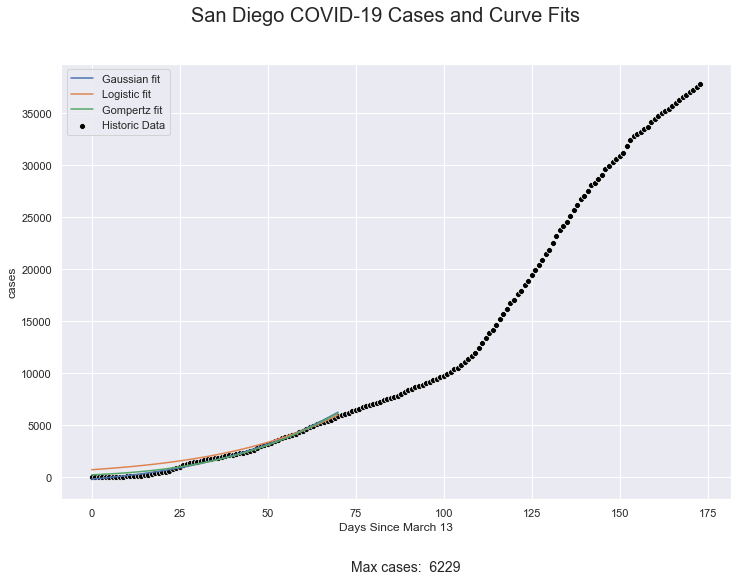

In [18]:
def ln_fit(df, fig, ax, col_name, use_smooth=True, pred_days = 70, text=True, fit_func = func_erf, label='', normalize=False):

    fit_col = col_name+'_smooth' if use_smooth else col_name
    
    t = df.dropna(subset=['day',fit_col])
    
    popt, pcov = curve_fit(fit_func, t.day, t[fit_col], p0=fit_func.popt, absolute_sigma = True)
   
    x=np.linspace(0,pred_days)
    proj = fit_func(x, *popt)
    
    sns.lineplot(x=x, y=proj/(proj.max() if normalize else 1), ax=ax, label=label)
    
    perr = np.sqrt(np.diag(pcov))
    
    max_cases = np.max(proj)
    
    if text: 
        plt.gcf().text(.46,-0,f"Max {col_name}: {max_cases:5.0f}", fontsize=14) 
    
    return popt, perr, x, proj

fig, ax = plt.subplots(figsize=(12,8))

t = df.copy()
#t.cases = lowess(df.cases, df.day, is_sorted=True, frac=0.4, it=0)[:,1]

popt, perr, x, cases_d_e = ln_fit(t[:], fig, ax, 'cases', fit_func = func_erf, label="Gaussian fit")
##print(f"Mean={round(popt[0])}, R^2={r2_score(t.cases, cases_d_e[:len(t.cases)])}")

popt, perr, x, cases_d_l = ln_fit(t[:], fig, ax, 'cases', text=False, fit_func = func_logistic, label='Logistic fit')
#print(f"Mean={round(popt[0])}, R^2={r2_score(t.cases, cases_d_l[:len(t.cases)])}")

popt, perr, x, cases_d_l = ln_fit(t[:], fig, ax, 'cases', text=False, fit_func = func_gomp, label='Gompertz fit')
#print(f"Mean={round(popt[0])}, R^2={r2_score(t.cases, cases_d_l[:len(t.cases)])}")
    
sns.scatterplot(x='day', y='cases', data=t, ax=ax, color='black', label='Historic Data')

    
    
    
ax.set_xlabel("Days Since March 13")   
fig.suptitle("San Diego COVID-19 Cases and Curve Fits", fontsize=20);


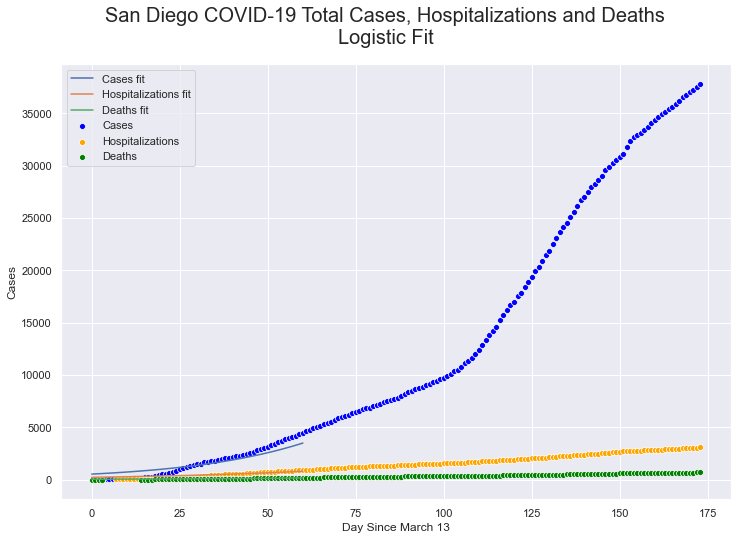

In [19]:
def tc_plot(ax, fit_func):

    t = df.dropna(subset=['day','cases','hosp', 'deaths']).copy()

    x = np.linspace(0,60)

    popt, pcov = curve_fit(fit_func, t.day, t.cases, p0=fit_func.popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Cases fit')
    sns.scatterplot(df.day, df.cases, ax=ax, color='blue', label='Cases')    
    #print(f"C Mean={round(popt[0])}, R^2={r2_score(df.cases, fitted[:len(df.cases)])}")

    popt, pcov = curve_fit(fit_func, t.day, t.hosp,popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Hospitalizations fit')
    sns.scatterplot(df.day, df.hosp,  ax=ax, color='orange', label='Hospitalizations')
    #print(f"H Mean={round(popt[0])}, R^2={r2_score(df.hosp.fillna(0), fitted[:len(df.hosp)])}")

    popt, pcov = curve_fit(fit_func, t.day, t.deaths,popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Deaths fit')
    #sns.lineplot(x=df.day, y=df.deaths_smooth, ax=ax, label='Deaths')   
    sns.scatterplot(t.day, t.deaths+1, ax=ax, color='green', label='Deaths')
    #print(f"D Mean={round(popt[0])}, R^2={r2_score(df.deaths.fillna(0), fitted[:len(df.deaths)])}")

    
fig, ax = plt.subplots(figsize=(12,8))   
tc_plot(ax, func_logistic)
ax.set_ylabel('Cases')
ax.set_xlabel('Day Since March 13')
fig.suptitle("San Diego COVID-19 Total Cases, Hospitalizations and Deaths\nLogistic Fit", fontsize=20);

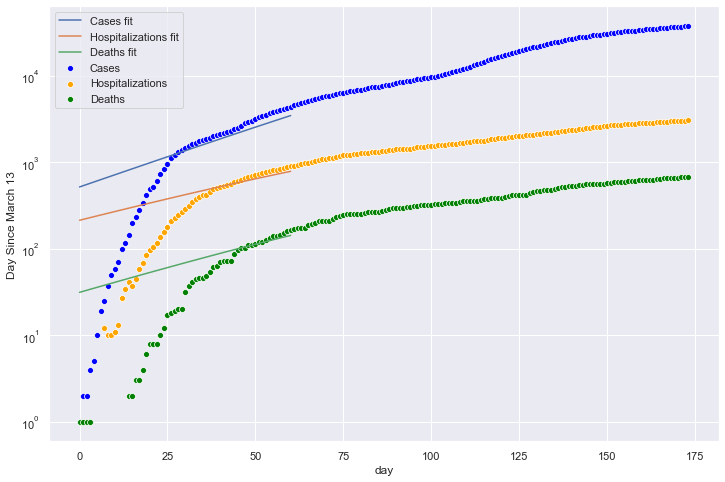

In [20]:
fig, ax = plt.subplots(figsize=(12,8))

tc_plot(ax, func_logistic)

plt.yscale('log')

ax.set_ylabel('Cases')
ax.set_ylabel('Day Since March 13');

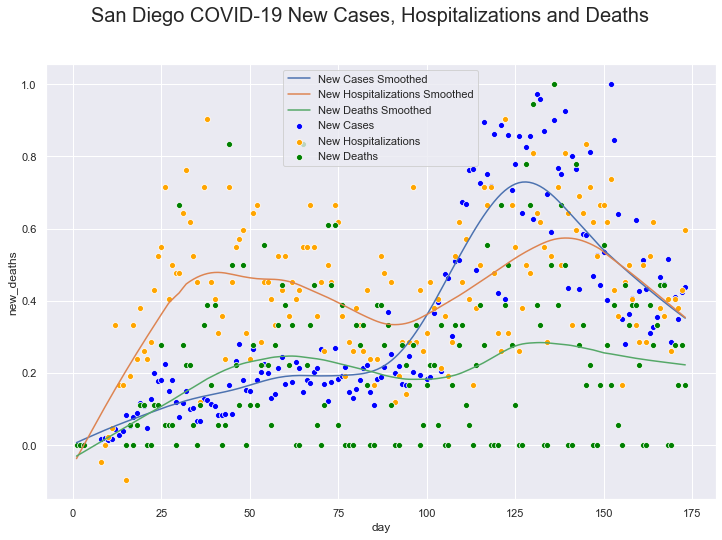

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths", fontsize=20);


smoothing = 0.3

fit_func = func_logpdf 

t = df.dropna(subset=['day','new_cases','new_hosp']).copy()

t.new_hosp = t.new_hosp/np.max(t.new_hosp)
t.new_cases = t.new_cases/np.max(t.new_cases)
t.new_deaths = t.new_deaths/np.max(t.new_deaths)

x = np.linspace(0,60)

sns.scatterplot(df.day, t.new_cases, ax=ax, color='blue', label='New Cases')
smoothed = lowess(t.new_cases,  t.day,smoothing)
sns.lineplot(smoothed[:,0], smoothed[:,1], label='New Cases Smoothed')

sns.scatterplot(df.day, t.new_hosp, ax=ax, color='orange', label='New Hospitalizations')
smoothed = lowess(t.new_hosp,  t.day, smoothing)
sns.lineplot(smoothed[:,0], smoothed[:,1], label='New Hospitalizations Smoothed')


sns.scatterplot(t.day, t.new_deaths, ax=ax, color='green', label='New Deaths')
smoothed = lowess(t.new_deaths,  t.day, smoothing)
sns.lineplot(smoothed[:,0], smoothed[:,1], label='New Deaths Smoothed')

In [22]:
t = pd.Timestamp('2020-03-13', freq='D') 
t + t.freq*42

Timestamp('2020-04-24 00:00:00', freq='D')

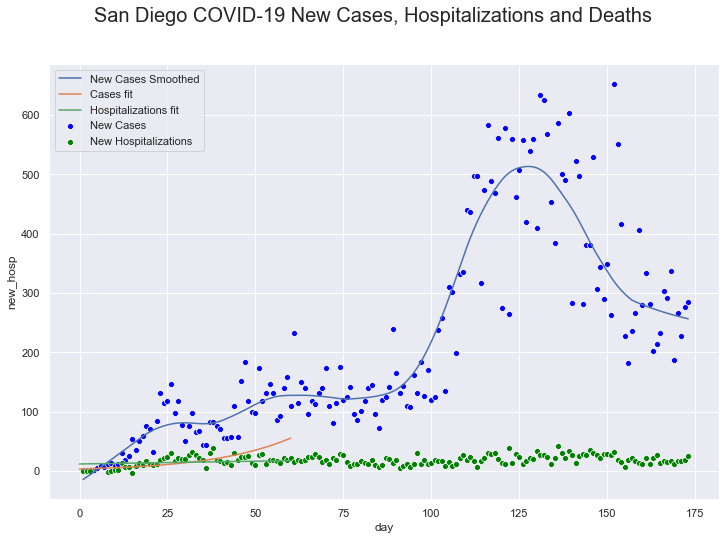

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths", fontsize=20);

def nc_plot(df, pct_cases=None, cases_only=False):
    # Fit a normal PDF

    fit_func = func_logpdf or fit_func

    if pct_cases:
        df = df.iloc[:int(pct_cases*len(df))]
    
    t = df.dropna(subset=['day','new_cases','new_hosp']).copy()


    x = np.linspace(0,60)

    sns.scatterplot(df.day, df.new_cases, ax=ax, color='blue', label='New Cases')

    tdl = lowess(df.new_cases,  df.day, 0.2)
    sns.lineplot(tdl[:,0], tdl[:,1], label='New Cases Smoothed')

    popt, pcov = curve_fit(fit_func, t.day, t.new_cases, p0=fit_func.popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Cases fit')
    
    #if not cases_only:
    #    print(f"C: Mean={round(popt[0])}, R^2={r2_score(df.new_cases[1:], fitted[1:len(df.new_cases)])}")
    
    if not cases_only:
        
        sns.scatterplot(df.day, df.new_hosp,  ax=ax, color='green', label='New Hospitalizations')

        popt, pcov = curve_fit(fit_func, t.day, t.new_hosp,popt, absolute_sigma = True)
        fitted = fit_func(x, *popt)
        sns.lineplot(x, fitted, label='Hospitalizations fit')

        #print(f"H: Mean={round(popt[0])}, R^2={r2_score(df.new_hosp[1:], fitted[1:len(df.new_hosp)])}")

        #popt, pcov = curve_fit(func_norm, t.day, t.new_deaths,popt, absolute_sigma = True)
        #sns.lineplot(x, func_norm(x, *popt), label='Deaths fit')  
        #sns.scatterplot(t.day, t.new_deaths, ax=ax, color='green', label='Deaths')
        #print(round(popt[0]))

        
nc_plot(df,1, cases_only=False)


### Regression Analysis

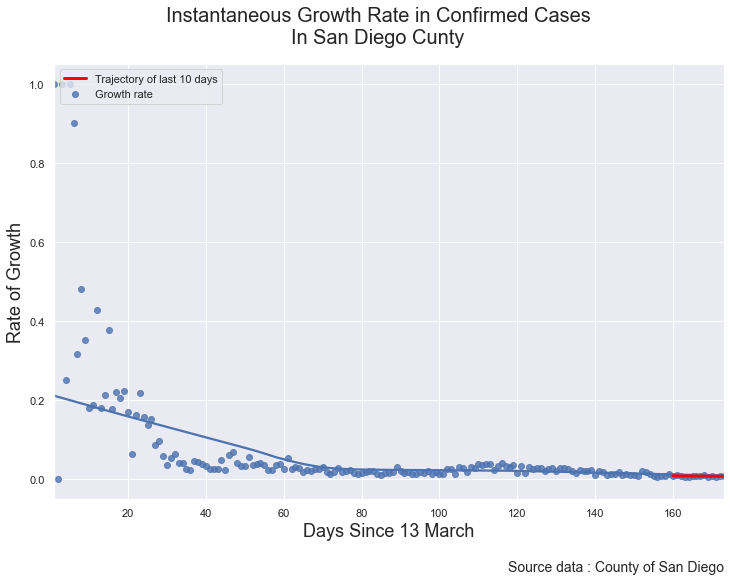

Coefficients: [[-8.15118664e-05]] [0.02100112]
Zero growth at 257.6449113787046 days
R2 = 0.06338097986161106
Mean Squared Error = 1.5955082851667783e-06
Root Mean Squared Error = [0.00126313]


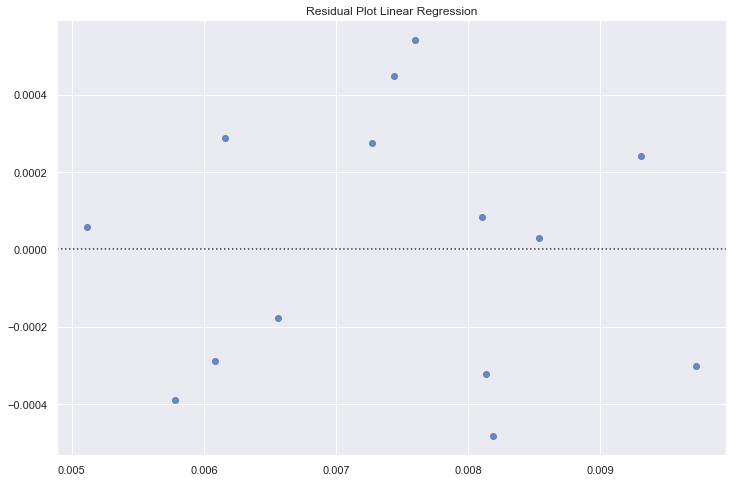

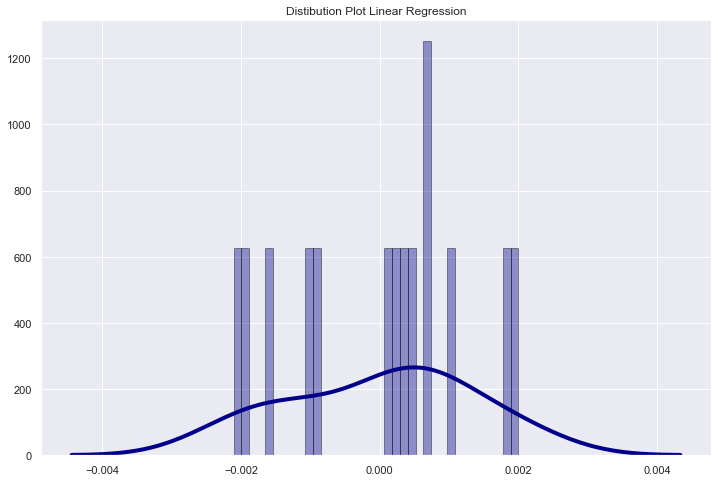

In [24]:
def plot_gr(df, col):

    x = df.day.values.reshape(len(df), 1)[-14:]
    y = df[col].values.reshape(len(df), 1)[-14:]

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    fig, ax = plt.subplots(figsize=(12,8))
    fig.suptitle('Instantaneous Growth Rate in Confirmed Cases\nIn San Diego Cunty',fontsize=20)

    sns.regplot(ax=ax, x='day',y=col, data=df, lowess=True, label = 'Growth rate')

    ax.plot(x, regr.predict(x), color='red', linewidth=3, label = 'Trajectory of last 10 days')

    ax.set_xlabel('Days Since 13 March', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

   
    plt.gcf().text(.65,0, f"Source data : County of San Diego", fontsize=14) 
    ax.legend(loc='upper left');
    plt.show()

    print('Coefficients:', regr.coef_, regr.intercept_)

    m = regr.coef_[0][0]
    b = regr.intercept_[0]

    
    
    print(f"Zero growth at {-b/m} days")
    
    
    y_pred = regr.predict(x)
    reg_r2 = r2_score(y, y_pred) # calculate r2 score
    reg_mse = mean_squared_error(y,y_pred) # calculate mean squared error
    reg_rmse = rmse(y, y_pred) # calaute root mean squared error
    print('R2 =',reg_r2) 
    print('Mean Squared Error =',reg_mse)
    print('Root Mean Squared Error =',reg_rmse)
    
    
    residuals = y-y_pred
    fig, ax = plt.subplots(figsize=(12,8))
    sns.residplot(y,residuals) # plot residual graph
    plt.title('Residual Plot Linear Regression')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12,8))
        # plot distribution graph
    sns.distplot(residuals, hist=True, kde=True, 
                 bins=int(180/5), color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})
    plt.title('Distibution Plot Linear Regression')
    plt.show()

plot_gr(df.dropna(subset=['cases_rate']), 'cases_rate')